In [113]:
%pip install opencv-python tqdm

Note: you may need to restart the kernel to use updated packages.


In [114]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
from cv2 import imread
import matplotlib.pyplot as plt
import io

In [115]:
import warnings
warnings.filterwarnings("ignore")

In [116]:
import xml.etree.ElementTree as ET
import tqdm


def crop_image(image, bndbox):
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    return image[ymin:ymax, xmin:xmax]


class StanfordDogsDataset(Dataset):
    def __init__(self, root_dir, limit_classes=10000, limit_img_per_class=10000, transform=None):
        self.root_dir = root_dir
        self.img_names = []
        self.bndx = []
        self.breed = []
        self.label_to_idx = dict()
        self.transform = transform

        annotations_dir = os.path.join(self.root_dir, 'annotations', 'Annotation')
        images_dir = os.path.join(self.root_dir, 'images', 'Images')

        annotations = os.listdir(annotations_dir)
        for _, annotation_dir_name in zip(range(limit_classes), annotations):
            category_img_dir = os.path.join(images_dir, annotation_dir_name)
            annotation_dir = os.path.join(annotations_dir, annotation_dir_name)
            images_names = os.listdir(category_img_dir)

            for _, image_name in zip(range(limit_img_per_class), images_names):
                ann = ET.parse(os.path.join(annotation_dir, image_name.split('.')[0])).getroot()
                obj = ann.find('object')
                name = obj.find('name').text
                bndbox = obj.find('bndbox')
                
                if name not in self.label_to_idx:
                    self.label_to_idx[name] = len(self.label_to_idx)


                self.img_names.append(os.path.join(category_img_dir, image_name))
                self.bndx.append(bndbox)
                self.breed.append(name)

        # print(len(self.img_names))

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ann = self.breed[idx]
        bndbox = self.bndx[idx]

        img = imread(self.img_names[idx])
        img = crop_image(img, bndbox)


        if self.transform:
            img = self.transform(img)

        # print(type(image))

        return img.to(torch.float), self.label_to_idx[ann]

In [149]:
# CNN model
class HashingNet(torch.nn.Module):
    def __init__(self, encoding_size):
        super().__init__()
        self.encoding_size = encoding_size
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 3, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(1, 3),
            torch.nn.Linear(6272, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, encoding_size),
            torch.nn.Sigmoid(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(encoding_size, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 6272),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (128,7,7)),

            torch.nn.ConvTranspose2d(128, 64, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Upsample(size=(31,31)),

            torch.nn.ConvTranspose2d(64, 32, 3, 2),
            torch.nn.ReLU(),

            torch.nn.Upsample(size=(127,127)),

            torch.nn.ConvTranspose2d(32, 3, 3, 2),
            torch.nn.Upsample(size=(512,512)),

            torch.nn.ReLU(),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        if self.training:
            decoded = self.decoder(encoded)
            return decoded
        return encoded
        buff = io.BytesIO()
        torch.save(x, buff)
        buff.seek(0)
        return buff.read()


class Classifier(torch.nn.Module):
    def __init__(self, encoding_size=1024, classes=10):
        super().__init__()
        self.pool = torch.nn.MaxPool2d(2)
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten(1, 3)
        self.sigmoid = torch.nn.Sigmoid()

        self.conv1 = torch.nn.Conv2d(3, 32, 3, 2)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 2)
        self.conv3 = torch.nn.Conv2d(64, 128, 3, 2)
        self.fc1 = torch.nn.Linear(6272, 2048)
        self.fc2 = torch.nn.Linear(2048, encoding_size)

        self.last = torch.nn.Linear(encoding_size, classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        x = self.last(x)

        return x


import random

def accuracy_test(model, loader):
    model.eval()
    correct = 0
    total = 0

    subset = torch.utils.data.Subset(loader.dataset, random.sample(range(len(loader.dataset)), 200))
    # print(len(subset))
    # print(subset[0])
    with torch.no_grad():
        for data in torch.utils.data.DataLoader(subset):
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total


def train_classifier(model, train_loader, optimizer, epochs=5):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(tqdm.tqdm(train_loader), 0):
            inputs, labels = data
            # labels = torch.tensor([int(label) for label in labels])
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 50 == 49:
                acc = accuracy_test(model, train_loader)
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 1000}, accuracy: {acc}')
        acc = accuracy_test(model, train_loader)
        print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 1000}, accuracy: {acc}')
                

def train_autoencoder(model, train_loader, optimizer, epochs=5):
    model.train()
    criterion = torch.nn.L1Loss()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (data, _) in enumerate(tqdm.tqdm(train_loader), 0):
            optimizer.zero_grad()
            outputs = model(data)
            #print(outputs.shape)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 1000}')
        

In [190]:
from torch import nn

def transpose_conv_layer(conv_layer):
    """
    Transpose a pretrained Conv2d layer into a ConvTranspose2d layer.

    Args:
        conv_layer (nn.Conv2d): The pretrained Conv2d layer to transpose.

    Returns:
        nn.ConvTranspose2d: The transposed Conv2d layer as a ConvTranspose2d layer.
    """
    if not isinstance(conv_layer, nn.Conv2d):
        raise TypeError("The provided layer must be an instance of nn.Conv2d")

    # Extract weights and biases
    weights = conv_layer.weight
    biases = conv_layer.bias

    # Initialize a ConvTranspose2d layer
    conv_transpose = nn.ConvTranspose2d(
        in_channels=conv_layer.out_channels,
        out_channels=conv_layer.in_channels,
        kernel_size=conv_layer.kernel_size,
        stride=conv_layer.stride,
        padding=conv_layer.padding,
        output_padding=conv_layer.output_padding if hasattr(conv_layer, 'output_padding') else 0
    )

    # Copy weights and biases into the ConvTranspose2d layer
    # conv_transpose.weight.data = weights.data.T.contiguous()
    # print(weights.data.shape)
    # print(weights.data.permute(1, 0, 2, 3).contiguous().shape)
    conv_transpose.weight.data = weights.data.clone()
    # conv_transpose.weight.data = weights.data.permute(1, 0, 2, 3).contiguous()
    # conv_transpose.bias.data = biases.data.clone()

    return conv_transpose



def copy_weights_from_classifier(classifier, hashing_net):
    with torch.no_grad():
        # Copy encoder weights
        hashing_net.encoder[0].weight.copy_(classifier.conv1.weight)
        hashing_net.encoder[0].bias.copy_(classifier.conv1.bias)

        hashing_net.encoder[3].weight.copy_(classifier.conv2.weight)
        hashing_net.encoder[3].bias.copy_(classifier.conv2.bias)

        hashing_net.encoder[6].weight.copy_(classifier.conv3.weight)
        hashing_net.encoder[6].bias.copy_(classifier.conv3.bias)

        hashing_net.encoder[10].weight.copy_(classifier.fc1.weight)
        hashing_net.encoder[10].bias.copy_(classifier.fc1.bias)

        hashing_net.encoder[12].weight.copy_(classifier.fc2.weight)
        hashing_net.encoder[12].bias.copy_(classifier.fc2.bias)

        # Copy decoder weights (transposed from encoder weights)
        hashing_net.decoder[0].weight.copy_(classifier.fc2.weight.T)
        # hashing_net.decoder[0].bias.copy_(classifier.fc2.bias)

        hashing_net.decoder[2].weight.copy_(classifier.fc1.weight.T)
        # hashing_net.decoder[2].bias.copy_(classifier.fc1.bias)

        hashing_net.decoder[5] = transpose_conv_layer(classifier.conv3)
        # hashing_net.decoder[5].weight.copy_(classifier.conv3.weight.T)
        # hashing_net.decoder[5].bias.copy_(classifier.conv3.bias)

        hashing_net.decoder[8] = transpose_conv_layer(classifier.conv2)
        # hashing_net.decoder[8].weight.copy_(classifier.conv2.weight.T)
        # hashing_net.decoder[8].bias.copy_(classifier.conv2.bias)

        hashing_net.decoder[11] = transpose_conv_layer(classifier.conv1)
        # hashing_net.decoder[11].weight.copy_(classifier.conv1.weight.T)
        # hashing_net.decoder[11].bias.copy_(classifier.conv1.bias)


def compare(encoder, dataset, i1, i2):
    # get 2 random images and their label
    encoder.eval()
    img1, lab1 = dataset[i1]
    img2, lab2 = dataset[i2]

    # forward pass on 2 images
    output1 = encoder(img1.unsqueeze(0))
    output2 = encoder(img2.unsqueeze(0))


    # calculate cosine similarity
    cos = torch.nn.CosineSimilarity(dim=1)

    return lab1 == lab2, cos(output1, output2)

In [119]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512))
])

trainset = StanfordDogsDataset('./dogs', limit_classes=10, limit_img_per_class=200, transform=data_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

In [120]:
from torch.utils.data import Subset

print("train dataset size:", len(trainset))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

encoding_size = 64
classifier = Classifier(encoding_size=encoding_size, classes=10)
hashNet = HashingNet(encoding_size=encoding_size)

cl_opt = torch.optim.Adam(classifier.parameters(), lr=0.001)

train dataset size: 1655


In [146]:
train_classifier(classifier, train_loader, cl_opt, epochs=6)

 48%|████▊     | 50/104 [00:49<02:21,  2.62s/it]

[1, 50] loss: 0.07177869153022766, accuracy: 0.545


 96%|█████████▌| 100/104 [01:50<00:13,  3.31s/it]

[1, 100] loss: 0.14095773327350616, accuracy: 0.595


100%|██████████| 104/104 [01:53<00:00,  1.09s/it]


[1, 104] loss: 0.1470206744670868, accuracy: 0.57


 48%|████▊     | 50/104 [00:56<02:29,  2.76s/it]

[2, 50] loss: 0.05959288114309311, accuracy: 0.75


 96%|█████████▌| 100/104 [01:55<00:15,  3.81s/it]

[2, 100] loss: 0.1174282009601593, accuracy: 0.8


100%|██████████| 104/104 [01:58<00:00,  1.14s/it]


[2, 104] loss: 0.12168429630994797, accuracy: 0.76


 48%|████▊     | 50/104 [01:03<02:36,  2.90s/it]

[3, 50] loss: 0.043797861516475675, accuracy: 0.845


 96%|█████████▌| 100/104 [02:01<00:13,  3.29s/it]

[3, 100] loss: 0.08645312464237213, accuracy: 0.88


100%|██████████| 104/104 [02:04<00:00,  1.20s/it]


[3, 104] loss: 0.09073119968175888, accuracy: 0.86


 48%|████▊     | 50/104 [01:11<03:35,  3.99s/it]

[4, 50] loss: 0.029423709839582445, accuracy: 0.93


 96%|█████████▌| 100/104 [02:18<00:16,  4.06s/it]

[4, 100] loss: 0.05563233971595764, accuracy: 0.92


100%|██████████| 104/104 [02:22<00:00,  1.37s/it]


[4, 104] loss: 0.057479518085718155, accuracy: 0.95


 48%|████▊     | 50/104 [01:06<03:03,  3.39s/it]

[5, 50] loss: 0.015479114681482315, accuracy: 0.95


 96%|█████████▌| 100/104 [02:00<00:11,  2.81s/it]

[5, 100] loss: 0.030644981637597084, accuracy: 0.985


100%|██████████| 104/104 [02:03<00:00,  1.19s/it]


[5, 104] loss: 0.03190221610665321, accuracy: 0.995


In [147]:
copy_weights_from_classifier(classifier, hashNet)

In [157]:
optimizer = torch.optim.Adam(hashNet.parameters(), lr=0.0005)
train_autoencoder(hashNet, train_loader, optimizer, epochs=5)

100%|██████████| 104/104 [02:34<00:00,  1.49s/it]


[1, 104] loss: 0.0328227156996727


100%|██████████| 104/104 [02:37<00:00,  1.51s/it]


[2, 104] loss: 0.03276018053293228


100%|██████████| 104/104 [02:46<00:00,  1.60s/it]


[3, 104] loss: 0.03271762576699257


100%|██████████| 104/104 [02:46<00:00,  1.60s/it]


[4, 104] loss: 0.03261820393800736


100%|██████████| 104/104 [02:56<00:00,  1.70s/it]

[5, 104] loss: 0.03258539122343063


In [168]:
_, l = trainset[12]
l

0

In [ ]:
ax[0][i].imshow(trainset[idx][0].permute(1, 2, 0))


In [169]:
_, l = trainset[11]
l

0

In [172]:
_, l = trainset[200]
l

1

In [193]:
compare(hashNet, trainset, 11, 12)

(True, tensor([0.7998], grad_fn=<SumBackward1>))

In [192]:
compare(hashNet, trainset, 11, 200)

(False, tensor([0.6088], grad_fn=<SumBackward1>))

In [150]:
img = trainset[0][0]
img = img[None, :, :, :]
hashNet.eval()
hsh = hashNet(img)
print(hsh)

tensor([[1.0000e+00, 1.9919e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.7557e-22,
         6.5655e-02, 1.4052e-10, 1.0000e+00, 3.8019e-09, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 5.1931e-07, 1.0000e+00, 1.0000e+00, 5.4809e-14, 6.9679e-06,
         1.0000e+00, 8.6241e-01, 1.0000e+00, 2.3825e-01, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9995e-01, 1.0000e+00,
         1.2241e-01, 1.0000e+00, 3.0760e-01, 9.9899e-01, 9.9998e-01, 2.0027e-15,
         1.0000e+00, 8.8494e-01, 1.0000e+00, 9.5398e-01, 1.7807e-12, 1.0000e+00,
         1.0000e+00, 2.9074e-01, 9.9793e-01, 6.0846e-06, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 5.2124e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 4.3362e-01, 6.5044e-32]],
       grad_fn=<SigmoidBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

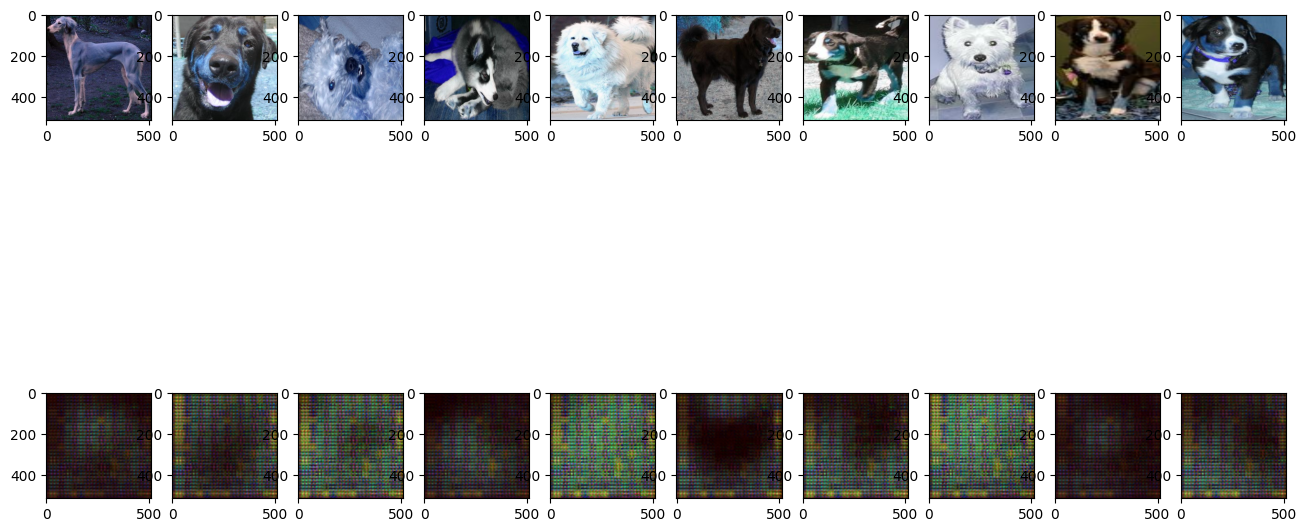

In [186]:
encoded_imgs = []
decoded_imgs = []

plt.rcParams["figure.figsize"] = [16, 9]
def compare_with_reconstructions(trainset, hashNet):
    fig, ax = plt.subplots(2, 10)

    random_imgs = random.sample(range(len(trainset)), 10)

    hashNet.train()
    for i, idx in enumerate(random_imgs):
        img = trainset[idx][0]
        img = img[None, :, :, :]
        decoded = hashNet(img)
        decoded = torch.squeeze(decoded)
        # decoded = (decoded - decoded.min()) / (decoded.max() - decoded.min())
        # print(type(decoded))
        ax[0][i].imshow(trainset[idx][0].permute(1, 2, 0))
        ax[1][i].imshow(decoded.permute(1, 2, 0).detach().numpy())

    plt.show()

compare_with_reconstructions(trainset, hashNet)

In [141]:
myHash = ""
hsh_norm = torch.round(hsh.squeeze() * 62 + 48).to(torch.int32)
for i in range(encoding_size):
    let = hsh_norm[i] + 7*int(84 > hsh_norm[i] > 57) + 13*int(83 < hsh_norm[i])
    myHash += chr(let)

In [142]:
hsh_norm[0]

tensor(110, dtype=torch.int32)

In [143]:
print(chr(60))

<


In [166]:
myHash

'{{0{{{4w0J{{z{{Ht{{n1{0{{{{{{3{0{{{p{{v0{0{vxr{{g000{{{1x{{{fP{0'

In [158]:
encoding_size=1
cl2 = Classifier(encoding_size=encoding_size, classes=10)
hshNet2 = HashingNet(encoding_size=encoding_size)

In [159]:
cl2_opt = torch.optim.Adam(cl2.parameters(), lr=0.001)
train_classifier(cl2, train_loader, cl2_opt, epochs=6)

 48%|████▊     | 50/104 [01:02<02:12,  2.46s/it]

[1, 50] loss: 0.12177815651893616, accuracy: 0.105


 96%|█████████▌| 100/104 [01:46<00:09,  2.47s/it]

[1, 100] loss: 0.24019283056259155, accuracy: 0.095


100%|██████████| 104/104 [01:49<00:00,  1.05s/it]


[1, 104] loss: 0.24924805402755737, accuracy: 0.07


 48%|████▊     | 50/104 [00:42<02:10,  2.42s/it]

[2, 50] loss: 0.11905446481704712, accuracy: 0.11


 96%|█████████▌| 100/104 [01:24<00:09,  2.46s/it]

[2, 100] loss: 0.23839178538322447, accuracy: 0.075


100%|██████████| 104/104 [01:28<00:00,  1.18it/s]


[2, 104] loss: 0.2474015998840332, accuracy: 0.115


 48%|████▊     | 50/104 [00:46<02:38,  2.94s/it]

[3, 50] loss: 0.11774104928970337, accuracy: 0.12


 96%|█████████▌| 100/104 [01:35<00:10,  2.60s/it]

[3, 100] loss: 0.2366770884990692, accuracy: 0.07


100%|██████████| 104/104 [01:37<00:00,  1.06it/s]


[3, 104] loss: 0.24593723130226136, accuracy: 0.135


 48%|████▊     | 50/104 [00:54<02:45,  3.06s/it]

[4, 50] loss: 0.11803517150878906, accuracy: 0.115


 96%|█████████▌| 100/104 [01:56<00:14,  3.53s/it]

[4, 100] loss: 0.23522603940963746, accuracy: 0.11


100%|██████████| 104/104 [01:59<00:00,  1.15s/it]


[4, 104] loss: 0.24473712635040284, accuracy: 0.12


 48%|████▊     | 50/104 [00:52<02:25,  2.70s/it]

[5, 50] loss: 0.11695631790161133, accuracy: 0.125


 96%|█████████▌| 100/104 [01:42<00:10,  2.72s/it]

[5, 100] loss: 0.23417367339134215, accuracy: 0.135


100%|██████████| 104/104 [01:45<00:00,  1.02s/it]


[5, 104] loss: 0.24365379762649536, accuracy: 0.145


 48%|████▊     | 50/104 [00:51<02:46,  3.08s/it]

[6, 50] loss: 0.11676130390167236, accuracy: 0.105


 96%|█████████▌| 100/104 [01:48<00:11,  2.82s/it]

[6, 100] loss: 0.2332840163707733, accuracy: 0.145


100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


[6, 104] loss: 0.24270233035087585, accuracy: 0.085


In [160]:
copy_weights_from_classifier(cl2, hshNet2)

In [167]:
hn2_opt = torch.optim.Adam(hshNet2.parameters(), lr=0.0005)
train_autoencoder(hshNet2, train_loader, hn2_opt, epochs=5)

100%|██████████| 104/104 [01:59<00:00,  1.15s/it]


[1, 104] loss: 0.025390328109264372


 14%|█▍        | 15/104 [00:22<02:10,  1.47s/it]


KeyboardInterrupt: 

In [ ]:
compare_with_reconstructions(trainset, hashNet)